In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

macrodata = sm.datasets.macrodata.load_pandas().data
macrodata.index = pd.period_range('1959Q1', '2009Q3', freq='Q')

In [10]:
macrodata = pd.read_excel('data/macrodata.xlsx', index_col=0)

In [11]:
macrodata

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
1959-01-01,1959,1,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00
1959-04-01,1959,2,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74
1959-07-01,1959,3,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09
1959-10-01,1959,4,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06
1960-01-01,1960,1,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-07-01,2008,3,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
2008-10-01,2008,4,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
2009-01-01,2009,1,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71
2009-04-01,2009,2,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19


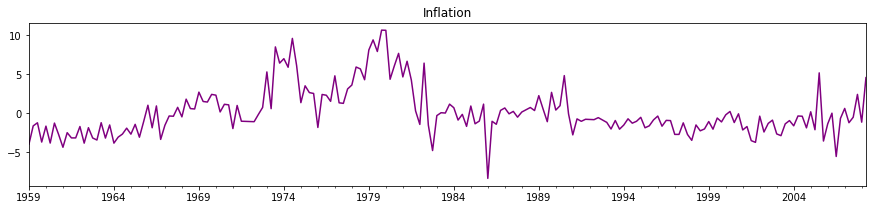

In [15]:
# De-mean the inflation series
y = macrodata['infl'] - macrodata['infl'].mean()

# plotting
y_pre = y.iloc[:-5]
y_pre.plot(figsize=(15, 3),color='purple', title='Inflation');

In [21]:
mod_pre = sm.tsa.arima.ARIMA(y_pre, order=(1, 0, 0), trend='n')
res_pre = mod_pre.fit()
print(res_pre.summary())
import warnings
warnings.filterwarnings("ignore")

                               SARIMAX Results                                
Dep. Variable:                   infl   No. Observations:                  198
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -446.407
Date:                Mon, 06 Jun 2022   AIC                            896.813
Time:                        14:14:25   BIC                            903.390
Sample:                    01-01-1959   HQIC                           899.475
                         - 04-01-2008                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6751      0.043     15.858      0.000       0.592       0.759
sigma2         5.3027      0.367     14.459      0.000       4.584       6.022
Ljung-Box (L1) (Q):                  15.65   Jarque-

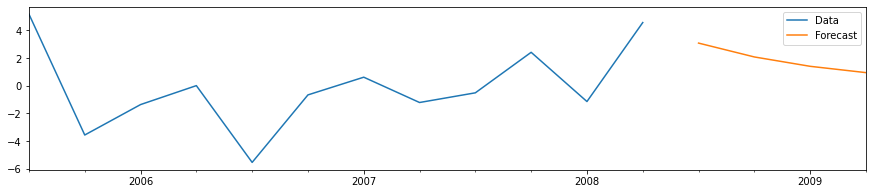

In [22]:
# Compute the forecasts
forecasts_pre = res_pre.forecast(4)

# Plot the last 3 years of data and the four out-of-sample forecasts
y_pre.iloc[-12:].plot(figsize=(15, 3), label='Data', legend=True)
forecasts_pre.plot(label='Forecast', legend=True);

In [23]:
# Get the estimated AR(1) coefficient
phi_hat = res_pre.params[0]

# Get the last observed value of the variable
y_T = y_pre.iloc[-1]

# Directly compute the forecasts at the horizons h=1,2,3,4
manual_forecasts = pd.Series([phi_hat * y_T, phi_hat**2 * y_T,
                              phi_hat**3 * y_T, phi_hat**4 * y_T],
                             index=forecasts_pre.index)

# We'll print the two to double-check that they're the same
print(pd.concat([forecasts_pre, manual_forecasts], axis=1))

            predicted_mean         0
2008-07-01        3.084388  3.084388
2008-10-01        2.082323  2.082323
2009-01-01        1.405812  1.405812
2009-04-01        0.949088  0.949088


In [24]:
# Get the next observation after the "pre" dataset
y_update = y.iloc[-5:-4]

# Print the forecast error
print('Forecast error: %.2f' % (y_update.iloc[0] - forecasts_pre.iloc[0]))

Forecast error: -10.21


In [25]:
# Create a new results object by passing the new observations to the `append` method
res_post = res_pre.append(y_update)

# Since we now know the value for 2008Q3, we will only use `res_post` to
# produce forecasts for 2008Q4 through 2009Q2
forecasts_post = pd.concat([y_update, res_post.forecast('2009Q2')])
print(forecasts_post)

2008-07-01   -7.121330
2008-10-01   -4.807732
2009-01-01   -3.245783
2009-04-01   -2.191284
dtype: float64


In [26]:
# Compute the impact of the news on the four periods that we previously
# forecasted: 2008Q3 through 2009Q2
news = res_pre.news(res_post, start='2008Q3', end='2009Q2')
# Note: one alternative way to specify these impact dates is
# `start='2008Q3', periods=4`

In [27]:
# Print the news, computed by the `news` method
print(news.news)

# Manually compute the news
print()
print((y_update.iloc[0] - phi_hat * y_pre.iloc[-1]).round(6))

update date  updated variable
2008-07-01   infl               -10.205718
Name: news, dtype: float64

-10.205718


In [28]:
# Print the total impacts, computed by the `news` method
# (Note: news.total_impacts = news.revision_impacts + news.update_impacts, but
# here there are no data revisions, so total and update impacts are the same)
print(news.total_impacts)

# Manually compute the impacts
print()
print(forecasts_post - forecasts_pre)

                 infl
2008-04-01   0.000000
2008-07-01 -10.205718
2008-10-01  -6.890055
2009-01-01  -4.651595
2009-04-01  -3.140371

2008-07-01   -10.205718
2008-10-01    -6.890055
2009-01-01    -4.651595
2009-04-01    -3.140371
dtype: float64


In [29]:
# Print the weights, computed by the `news` method
print(news.weights)

# Manually compute the weights
print()
print(np.array([1, phi_hat, phi_hat**2, phi_hat**3]).round(6))

impact date                  2008-04-01 2008-07-01 2008-10-01 2009-01-01  \
impacted variable                  infl       infl       infl       infl   
update date updated variable                                               
2008-07-01  infl                    0.0        1.0   0.675117   0.455783   

impact date                  2009-04-01  
impacted variable                  infl  
update date updated variable             
2008-07-01  infl               0.307707  

[1.       0.675117 0.455783 0.307707]


In [43]:
###

import pandas_datareader as pdr
levels = pdr.get_data_fred(['PCEPILFE', 'CPILFESL'], start='1999', end='2023').to_period('M')
infl = np.log(levels).diff().iloc[1:] * 1200
infl.columns = ['PCE', 'CPI']

# Remove two outliers and de-mean the series
infl['PCE'].loc['2001-09':'2001-10'] = np.nan

In [44]:
infl

,PCE,CPI
DATE,,
1999-02,-0.411363,0.000000
1999-03,0.365663,0.683177
1999-04,3.073258,4.090913
1999-05,1.154241,1.360544
1999-06,0.622222,0.679694
...,...,...
2021-12,6.100817,6.723156
2022-01,5.264391,6.978999
2022-02,3.645593,6.046932


In [45]:
# Previous dataset runs through 2017-02
y_pre = infl.loc[:'2022-01'].copy()
const_pre = np.ones(len(y_pre))
print(y_pre.tail())
y_pre

              PCE       CPI
DATE                       
2021-09  2.882884  3.050833
2021-10  5.644166  7.212130
2021-11  5.718180  6.262539
2021-12  6.100817  6.723156
2022-01  5.264391  6.978999


,PCE,CPI
DATE,,
1999-02,-0.411363,0.000000
1999-03,0.365663,0.683177
1999-04,3.073258,4.090913
1999-05,1.154241,1.360544
1999-06,0.622222,0.679694
...,...,...
2021-09,2.882884,3.050833
2021-10,5.644166,7.212130
2021-11,5.718180,6.262539


In [46]:
# For the updated dataset, we'll just add in the
# CPI value for 2022-03
y_post = infl.loc[:'2022-03'].copy()
y_post.loc['2022-03', 'PCE'] = np.nan
const_post = np.ones(len(y_post))

# Notice the missing value for PCE in 2022-03
print(y_post.tail())

              PCE       CPI
DATE                       
2021-11  5.718180  6.262539
2021-12  6.100817  6.723156
2022-01  5.264391  6.978999
2022-02  3.645593  6.046932
2022-03       NaN  3.882859


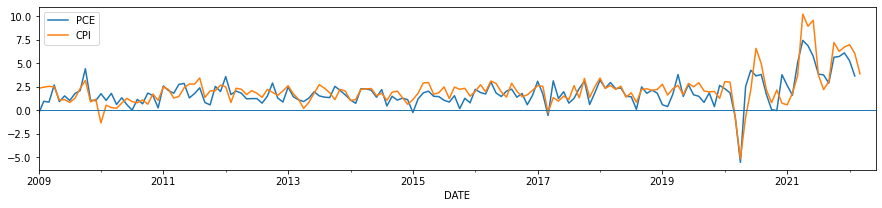

In [47]:
# Plot the updated dataset
fig, ax = plt.subplots(figsize=(15, 3))
y_post.plot(ax=ax)
ax.hlines(0, '2009', '2022-06', linewidth=1.0)
ax.set_xlim('2009', '2022-06');

In [48]:
mod_pre = sm.tsa.DynamicFactor(y_pre, exog=const_pre, k_factors=1, factor_order=6)
res_pre = mod_pre.fit()
print(res_pre.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.66041D+00    |proj g|=  2.96055D-01

At iterate    5    f=  4.66058D+00    |proj g|=  2.25803D-01


 This problem is unconstrained.



At iterate   10    f=  3.39821D+00    |proj g|=  4.34547D-01

At iterate   15    f=  3.25127D+00    |proj g|=  2.96817D-01

At iterate   20    f=  3.11175D+00    |proj g|=  4.38242D-02

At iterate   25    f=  3.08445D+00    |proj g|=  8.59593D-02

At iterate   30    f=  3.07493D+00    |proj g|=  5.13300D-02

At iterate   35    f=  3.06255D+00    |proj g|=  3.76266D-02

At iterate   40    f=  3.03843D+00    |proj g|=  8.85176D-02

At iterate   45    f=  3.00266D+00    |proj g|=  5.67313D-02

At iterate   50    f=  2.99369D+00    |proj g|=  1.00464D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     70   

In [49]:
# Create the news results
# Note
const_post_plus1 = np.ones(len(y_post) + 1)
news = res_pre.news(y_post, exog=const_post_plus1, start='2022-03', end='2022-04')

In [50]:
res_post = res_pre.apply(y_post, exog=const_post)
news = res_pre.news(res_post, exog=[1.], start='2022-03', end='2022-04')

In [51]:
# Show the summary of the news results
print(news.summary())

                                     News                                     
Model:                  DynamicFactor   Original sample:               1999-02
Date:                Mon, 06 Jun 2022                                - 2022-01
Time:                        14:21:05   Update through:                2022-04
                                        No. Revisions:                       0
                                        No. New datapoints:                  3
                                  Impacts                                  
impact date impacted variable estimate (prev) impact of news estimate (new)
---------------------------------------------------------------------------
    2022-03               CPI            4.59          -0.56           4.03
                          PCE            3.81          -0.44           3.36
    2022-04               CPI            2.63          -0.53           2.10
                          PCE            2.26          -0.42          

In [52]:
print(news.summary_details())


                                                       Details                                                        
update date updated variable   observed forecast (prev) impact date impacted variable       news     weight     impact
----------------------------------------------------------------------------------------------------------------------
    2022-02              CPI       6.05            5.48     2022-03               CPI       0.57       0.11       0.06
                                                                                  PCE       0.57       0.09       0.05
                                                            2022-04               CPI       0.57       0.15       0.09
                                                                                  PCE       0.57       0.12       0.07
                         PCE       3.65            4.50     2022-03               CPI      -0.86       0.05      -0.05
                                                